In [ ]:
# ===================================================================
# 共通セットアップセル (ローカル / Colab 共通)
# ===================================================================
import sys
import os
from pathlib import Path

# --- 1. 環境判別 ---
IN_COLAB = False
try:
    # Colab環境でのみインポートが成功する
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    pass # ローカル環境


if IN_COLAB:
    # ==================================
    # Colab 環境でのセットアップ
    # ==================================
    print("環境: Colab を検出。セットアップを開始します。")

    # 1. Google Driveのマウント
    drive.mount('/content/drive')

    # 2. GitHubリポジトリのクローンまたはプル
    repo_path = Path('/content/braidyn-bc')
    if repo_path.exists():
        print("リポジトリを pull します...")
        os.chdir(repo_path)
        !git pull
    else:
        print("リポジトリを clone します...")
        !git clone https://github.com/nyaamikeneko/braidyn-bc.git
        os.chdir(repo_path)

    # 3. 依存ライブラリのインストール
    print("依存ライブラリをインストールします...")
    !pip install -q pynwb git+https://github.com/BraiDyn-BC/bdbc-nwb-explorer.git

    # 4. sys.path の設定
    project_root = repo_path
    if str(project_root) not in sys.path:
        sys.path.append(str(project_root))

    print(f"セットアップ完了。プロジェクトルート: {project_root}")

else:
    # ==================================
    # ローカル (VSCode) 環境でのセットアップ
    # ==================================
    print("環境: ローカル (VSCode) を検出。")

    # 1. sys.path の設定
    current_dir = Path.cwd()
    if current_dir.name == 'notebooks':
        # ノートブックが notebooks/ から実行された場合
        project_root = current_dir.parent
    else:
        # プロジェクトルート (braidyn-bc/) から実行されたと仮定
        project_root = current_dir

    if str(project_root) not in sys.path:
        sys.path.append(str(project_root))

    print(f"プロジェクトルート: {project_root}")

# ===================================================================
# 共通インポート・処理
# (セットアップが完了したため、config.py や src/ が読み込める)
# ===================================================================
print("\n共通モジュールをインポートします...")

import bdbc_nwb_explorer as nwbx
import src.data_loader as dl
import config  # config.py もここで読み込める

print(f"データパス (DATA_NWB_ROOT): {config.DATA_NWB_ROOT}")

環境: Colab を検出。セットアップを開始します。
Mounted at /content/drive
リポジトリを clone します...
Cloning into 'braidyn-bc'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 101 (delta 33), reused 16 (delta 8), pack-reused 42 (from 1)
Receiving objects: 100% (101/101), 28.62 MiB | 30.18 MiB/s, done.
Resolving deltas: 100% (54/54), done.
依存ライブラリをインストールします...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 339.5/339.5 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.2/788.2 kB 45.2 MB/s eta 0:00:00
セットアップ完了。プロジェクトルート: /content/braidyn-bc

共通モジュールをインポートします...
環境: Colab
データパス (DATA_NWB_ROOT): /content/drive

In [ ]:
# --- 必要なデータを関数で読み出す ---
SESSION_ID = "VG1GC-66"
NWB_FILENAME = "VG1GC-66_2023-09-08_task-day15.nwb"
TASK_DAY_DIR = "task-day15"

# NWBデータの読み込み
# (dl は共通セルでインポート済み)
session = dl.load_nwb_session(SESSION_ID, NWB_FILENAME)

# CSVデータの読み込み
trials = dl.load_trials_csv(SESSION_ID, TASK_DAY_DIR)


--- 集計結果 (Threshold >= 0.04) ---
1. 音あり・成功 (Success)       : 63
2. 音あり・失敗 (Failure)       : 57
3. 音なしレバー引き (NS Pull)   : 455
4. 音なしレバーなし (NS NoPull) : 300 (Sampled 300/40258)
------------------------------
判定: mismatch (差分: -5)


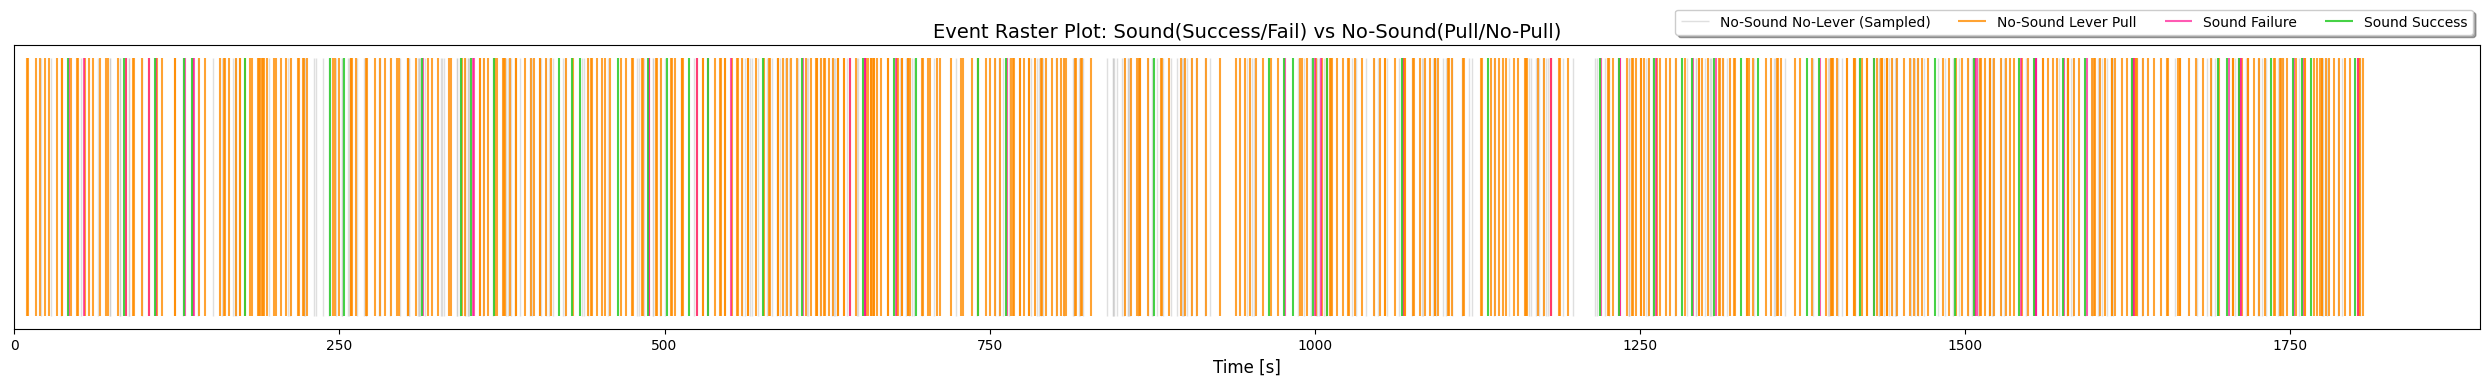

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 設定: 色と閾値 ---
# 視認性の高い配色設定
COLOR_SUCCESS = 'limegreen'      # 音あり成功 (明るい緑)
COLOR_FAILURE = 'deeppink'       # 音あり失敗 (濃いピンク/マゼンタ)
COLOR_NS_PULL = 'darkorange'     # 音なしレバー引き (オレンジ)
COLOR_NS_NOPULL = 'silver'       # 音なしレバー引きなし (グレー/背景的)

THRESHOLD_DIFF = 0.04            # フィルタ用閾値

# --- 1. データの抽出と分類 ---

# (A) 音あり成功試行 (Sound Success)
success_trials = trials[trials['trial_outcome'] == 'success'].copy()
success_start_times = (success_trials['pull_onset']).round(4)
success_times_set = set(success_start_times)
times_success = success_trials['pull_onset']

# (B) 音あり失敗試行 (Sound Failure)
candidate_mask = (trials['state_task'].isin([1, 2])) & (trials['diff_value'] >= THRESHOLD_DIFF)
candidates = trials[candidate_mask].copy()
candidates['calc_start_time'] = (candidates['t'] - candidates['diff_value']).round(4)
failure_trials = candidates[~candidates['calc_start_time'].isin(success_times_set)]
times_failure = failure_trials['calc_start_time']

# (C) 音なしレバー引き (No-Sound Lever Pull) ※名称変更
filtered_nosound_pull = trials[(trials['state_lever'] == 1) &
                               (trials['state_task'] == 0) &
                               (trials['diff_value'] > THRESHOLD_DIFF)].copy()
filtered_nosound_pull['lever_time_nocue'] = filtered_nosound_pull['t'] - filtered_nosound_pull['diff_value']
times_ns_pull = filtered_nosound_pull['lever_time_nocue']

# (D) 音なしレバー引きなし (No-Sound No-Lever) ※新規追加
# 条件: state_task=0, state_lever=0
no_action_mask = (trials['state_task'] == 0) & (trials['state_lever'] == 0)
no_action_trials = trials[no_action_mask].copy()
raw_times_no_action = no_action_trials['t']

# ランダムサンプリング (300試行)
SAMPLE_SIZE = 300
if len(raw_times_no_action) > SAMPLE_SIZE:
    # random_stateを指定して再現性を確保
    times_ns_nopull = raw_times_no_action.sample(n=SAMPLE_SIZE, random_state=42).sort_values()
    sample_note = f"(Sampled {SAMPLE_SIZE}/{len(raw_times_no_action)})"
else:
    times_ns_nopull = raw_times_no_action
    sample_note = f"(All {len(raw_times_no_action)})"

# --- 2. 数値の整合性確認 (デバッグ) ---
count_success = len(times_success)
count_failure = len(times_failure)
total_sound_processed = count_success + count_failure
raw_state_12_count = len(candidates)

print(f"--- 集計結果 (Threshold >= {THRESHOLD_DIFF}) ---")
print(f"1. 音あり・成功 (Success)       : {count_success}")
print(f"2. 音あり・失敗 (Failure)       : {count_failure}")
print(f"3. 音なしレバー引き (NS Pull)   : {len(times_ns_pull)}")
print(f"4. 音なしレバーなし (NS NoPull) : {len(times_ns_nopull)} {sample_note}")
print("-" * 30)
# 整合性チェック
if total_sound_processed == raw_state_12_count:
    print("判定: OK (音あり合計が元データ数と一致)")
else:
    print(f"判定: mismatch (差分: {raw_state_12_count - total_sound_processed})")

# --- 3. 可視化 (プロット) ---
plt.figure(figsize=(25, 4)) # 情報量が増えたため高さを拡張

# 各イベントの描画
# 4. 音なしレバーなし（背景的に一番後ろまたは薄く描画）
plt.vlines(times_ns_nopull, ymin=0, ymax=1, color=COLOR_NS_NOPULL, alpha=0.5, linewidth=1.0, label='No-Sound No-Lever (Sampled)')

# 3. 音なしレバー引き
plt.vlines(times_ns_pull, ymin=0, ymax=1, color=COLOR_NS_PULL, alpha=0.8, linewidth=1.5, label='No-Sound Lever Pull')

# 2. 音あり失敗
plt.vlines(times_failure, ymin=0, ymax=1, color=COLOR_FAILURE, alpha=0.7, linewidth=1.5, label='Sound Failure')

# 1. 音あり成功
plt.vlines(times_success, ymin=0, ymax=1, color=COLOR_SUCCESS, alpha=0.9, linewidth=1.5, label='Sound Success')

# 軸とラベル
plt.xlabel('Time [s]', fontsize=12)
plt.yticks([])
plt.title('Event Raster Plot: Sound(Success/Fail) vs No-Sound(Pull/No-Pull)', fontsize=14)

# 凡例
plt.legend(loc='upper right', framealpha=1.0, shadow=True, bbox_to_anchor=(1.0, 1.15), ncol=4)
plt.xlim(left=0)
plt.tight_layout()
plt.show()